In [312]:
import numpy as np
from scipy.stats import skewnorm, skew
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report

def simulate_data(classes, n_vars, n, max_mu, max_sigma, max_skew):
    #The multivariate skew normal number generator
    def rng(mu, sigma, skew, n=1):
        k = len(mu)
        if not (k == len(sigma) and k ==len(skew)): 
            raise Exception("Mu, Sigma and Skew should be same length")

        data = np.zeros((int(n),k))

        for i in range(k):
            data[:,i] = skewnorm.rvs(skew[i], loc=mu[i], scale=sigma[i], size=int(n)) 

        return data
    
    if(np.sum(classes) != 1):
        raise Exception("Classes dont sum up to 1")
        
    n_classes = len(classes)
    sigma = np.random.randint(1,max_sigma,n_vars)
    skew = np.random.randint(-max_skew,max_skew,n_vars)
    mu =  np.random.randint(-max_mu, max_mu, (n_classes, n_vars))
    
    n_obs_class = np.round(np.dot(classes,n))
    
    data = np.zeros((int(np.sum(n_obs_class)),n_vars+1))
    for i in range(n_classes):
        #calculate indexes
        start = int(np.sum(n_obs_class[0:i]))
        end = int(np.sum(n_obs_class[0:i+1]))
        
        #set the data
        data[start:end,0] = i
        data[start:end,1:] = rng(mu[i,:], sigma, skew, n_obs_class[i])
        
    X = data[:,1:]
    y = data[:,0]
    
    columns = ["x"+str(x) for x in range(n_vars + 1)]
    columns[0] = "class"
    
    df = pd.DataFrame(data,columns=columns)
    df["class"] = df["class"].astype(int)
    return X,y, df



#parameters
classes = [0.2, 0.2, 0.3, 0.3] #percentages
n_vars = 5
n = 100000
max_mu = 3
max_sigma = 20
max_skew = 5
np.random.seed(12345)

#generate data
X,y, df = simulate_data(classes, n_vars, n, max_mu, max_sigma, max_skew)

display(df.groupby(["class"]).agg(["count", "mean", "var"]))

#make train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)


x1                         x2                          x3            \
       count      mean       var  count      mean        var  count      mean   
class                                                                           
0      20000  0.036999  8.948877  20000 -6.579375  15.462360  20000 -1.547235   
1      20000 -2.010113  8.970896  20000 -4.478924  15.403076  20000  0.444503   
2      30000 -0.999721  9.107671  30000 -4.532702  15.558359  30000  0.451092   
3      30000 -2.007648  9.096073  30000 -4.579016  15.278446  30000 -0.545557   

                    x4                          x5                       
            var  count      mean        var  count      mean        var  
class                                                                    
0      1.607058  20000 -0.102490  17.140227  20000 -8.749262  40.456136  
1      1.625450  20000  1.826674  16.840767  20000 -9.747599  40.398315  
2      1.589937  30000 -0.185482  16.904527  30000 -5.729260  39.706603  
3      1.584718  30000 -0.186390  17.086592  30000 -7.737658  39.678322

LDA MSE is 1.7144545454545455
              precision    recall  f1-score   support

         0.0       0.57      0.56      0.56      6554
         1.0       0.46      0.34      0.39      6651
         2.0       0.49      0.60      0.54      9899
         3.0       0.45      0.44      0.44      9896

   micro avg       0.49      0.49      0.49     33000
   macro avg       0.49      0.48      0.48     33000
weighted avg       0.49      0.49      0.49     33000



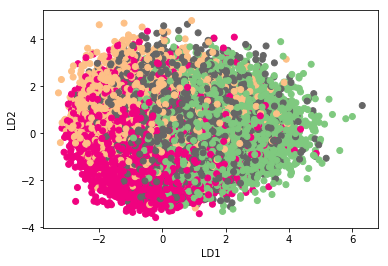

In [313]:
#LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(priors=classes)
X_lda = lda.fit_transform(X_train, y_train)



lda_pred = lda.predict(X_test)
lda_mse = mean_squared_error(y_test, lda_pred)
print("LDA MSE is "+ str(lda_mse))
# confusion_matrix(y_test, lda_pred)
print(classification_report(y_test, lda_pred))

plt.xlabel('LD1')
plt.ylabel('LD2')
plt.scatter(
    X_lda[:,0],
    X_lda[:,1],
    c=y_train,
    cmap='Accent',
#      alpha=0.7,
#      edgecolors='grey'
)

In [314]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial').fit(X_train, y_train)


clf_pred = clf.predict(X_test)
clf_mse = mean_squared_error(y_test, clf_pred)
print("Logistic MSE is "+ str(clf_mse))
# confusion_matrix(y_test, lda_pred)
# print(classification_report(y_test, clf_pred))

# plt.xlabel('LD1')
# plt.ylabel('LD2')
# plt.scatter(
#     clf[:,0],
#     clf[:,1],
#     c=y_train,
#     cmap='Accent',
# #      alpha=0.7,
# #      edgecolors='grey'
# )

Logistic MSE is 1.7104242424242424


C:\Users\Tim\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
